In [17]:
!nvidia-smi

Thu Aug 24 20:22:35 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |    633MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   30C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import pickle as pk
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


Load in the CSV files

In [3]:
%%time
modelpath   = "data/models/some-model-path.h5"
trainpath   = "data/sets/UNIF-10N-25T-1000E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)

CPU times: user 5.93 s, sys: 184 ms, total: 6.11 s
Wall time: 6.11 s


Make a list of events. Each event is a dataframe

In [4]:
%%time
train = utils.list_of_groups(train_frame, group="event_id")
test  = utils.list_of_groups(test_frame,  group="event_id")
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))

Train is list of 25000 events.
Test is list of 3600 events.
CPU times: user 4.5 s, sys: 76 ms, total: 4.58 s
Wall time: 4.57 s


In [10]:
order = ["phi", "r", "z"]

Train 13446
Number of Hits: 132
Number of Tracks: 9


<IPython.core.display.Javascript object>


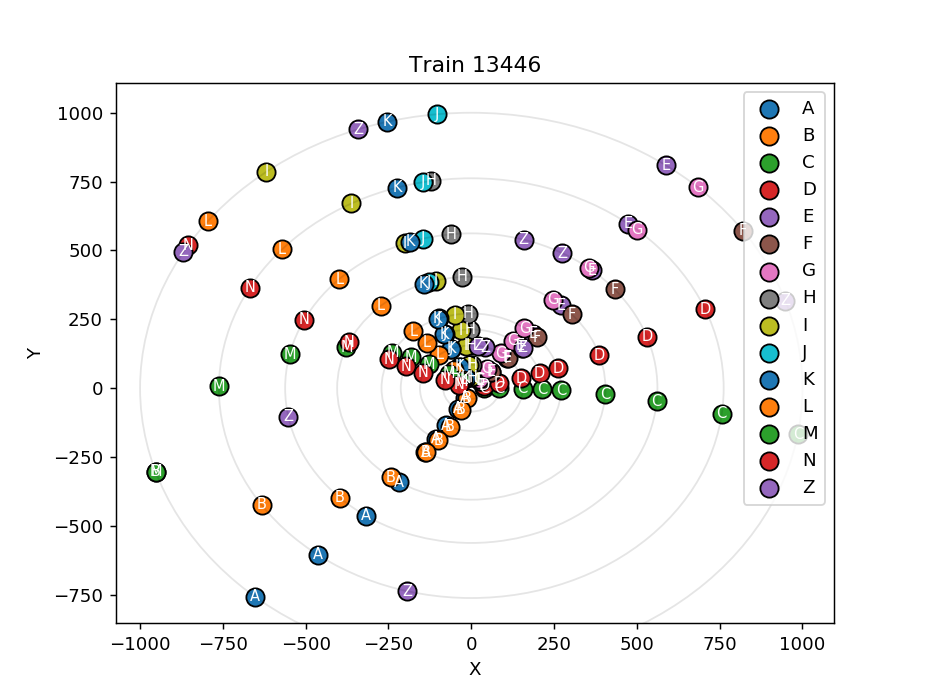

In [8]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [11]:
print(n)
visuals.display(train[n], order)

13446


,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.954730,562.0,131.661763,,,,,,,,,,,,,,,,,,,,,,,,,,1,
1,-2.833724,1000.0,-149.211247,,,,,,,,,,,,,1,,,,,,,,,,,,,,
2,-2.832647,1000.0,150.289590,,1,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.551488,762.0,114.520668,,1,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.356495,562.0,84.462750,,1,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.282794,1000.0,-82.481320,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.224101,762.0,-62.850766,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.215710,405.0,60.867284,,1,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.174752,562.0,-46.354502,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.137524,405.0,-33.404935,1,,,,,,,,,,,,,,,,,,,,,,,,,,


In [12]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [13]:
model = Sequential()
model.add(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax", input_shape=input_shape))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 235, 27)           108       
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


In [18]:
%%time
# 32 + 32 + 64 + 64
epochs     = 4
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,)]))

Epoch 1/4
250/250 [==============================] - 135s - loss: 4.9849 - acc: 0.5472 - val_loss: 2.8012 - val_acc: 0.6497
Epoch 2/4
250/250 [==============================] - 123s - loss: 3.4174 - acc: 0.5531 - val_loss: 2.5766 - val_acc: 0.6457
Epoch 3/4
250/250 [==============================] - 123s - loss: 3.0764 - acc: 0.5558 - val_loss: 2.3711 - val_acc: 0.6431
Epoch 4/4
250/250 [==============================] - 125s - loss: 2.8312 - acc: 0.5574 - val_loss: 2.1769 - val_acc: 0.6413
CPU times: user 8min 31s, sys: 7.16 s, total: 8min 38s
Wall time: 8min 28s


In [25]:
importlib.reload(metrics)

<module 'tracker.metrics' from '/home/jovyan/work/Fermi-Internship-2017/Track/tracker/metrics.py'>

In [26]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 9.088403665437465%
Percent of tracks assigned correctly: 0.0%
Percent of events with the correct number of tracks: 5.138888888888888%
CPU times: user 1min 7s, sys: 44 ms, total: 1min 7s
Wall time: 1min 7s


<IPython.core.display.Javascript object>


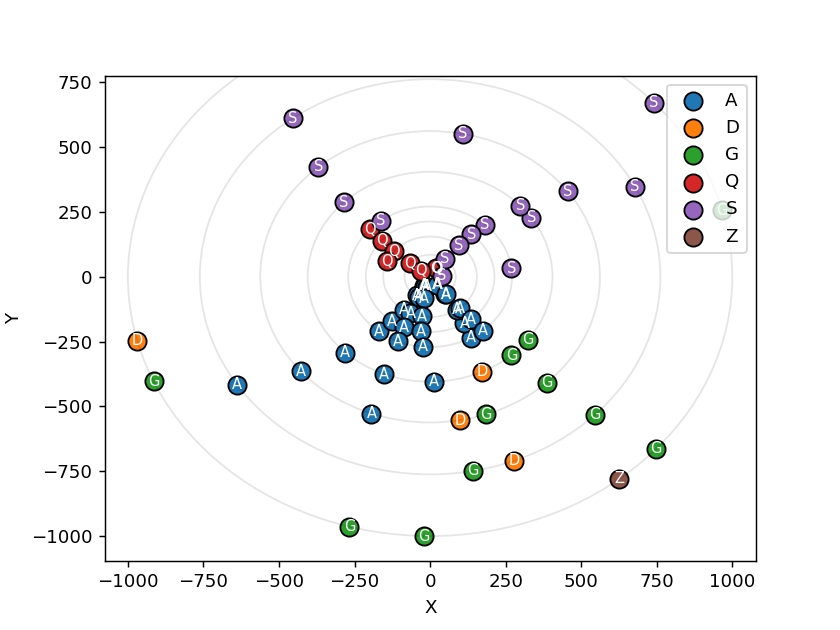

<IPython.core.display.Javascript object>


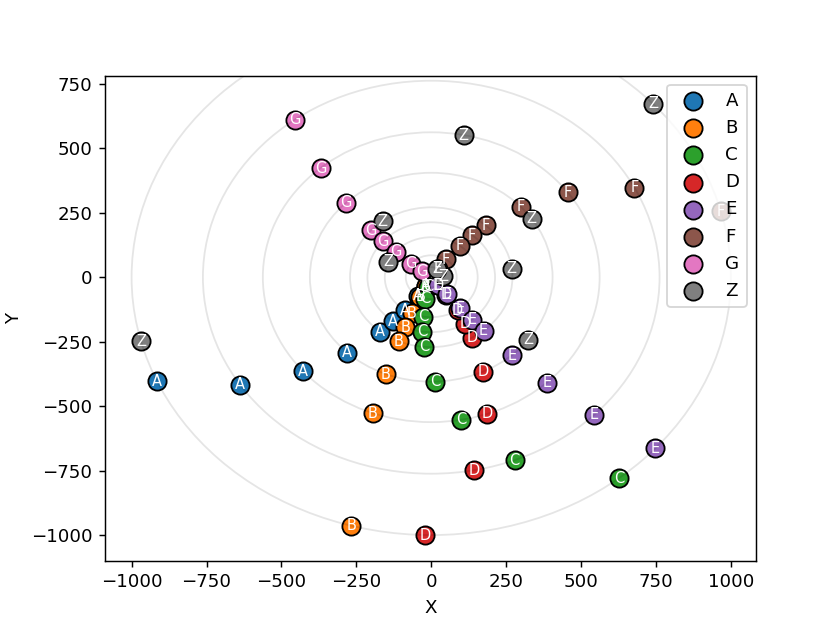

In [21]:
n = 6
d = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy")
d = visuals.Plot2D(test[n], order).plot(mode="xy")

In [22]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.891611,1000.0,0.378714,,,,`0`[1.0],,,,,,,,,,,,,,,,,,,,,,`1`[0.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,
1,-2.725844,1000.0,-158.601398,`1`[0.0],,,,,,`0`[1.0],,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.562788,762.0,-120.854266,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.435731,562.0,-89.133986,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.335917,405.0,-64.233566,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.249899,271.0,-42.980979,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.210670,213.0,-33.782098,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.174663,155.0,-24.583217,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.127336,85.0,-13.481119,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.082002,39.0,-6.185455,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
